# <a id='toc1_'></a>[<span style='color:gold;'>EEG Analysis</span>](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [<span style='color:gold;'>EEG Analysis</span>](#toc1_)    
- [Step 1: Import libraries](#toc2_)    
- [Step 2: Load and preprocess EEG data](#toc3_)    
  - [Step 2.1: Load the dataset](#toc3_1_)    
  - [Step 2.2: Critical preprocessing](#toc3_2_)    
  - [Step 2.3: Scale EEG to microvolts](#toc3_3_)    
- [Step 3: Time-Domain Analysis](#toc4_)    
  - [Step 3.1: Full 10-second plot](#toc4_1_)    
  - [Step 3.2: Short 0.5-second segment](#toc4_2_)    
- [Step 4: Frequency-Domain Analysis](#toc5_)    
- [Step 5: Spectrogram](#toc6_)    
- [Step 6: EEG Band Analysis](#toc7_)    
- [Step 7: Sonification](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Step 1: Import libraries](#toc0_)

In [1]:
import numpy as np
import mne
from IPython.display import HTML
import base64

ModuleNotFoundError: No module named 'mne'

In [ ]:
# Import module
from audio_visualization import (
    calculate_fft,
    plot_signal_and_fft,
    plot_spectrogram,
    plot_time_segment,
    DEFAULT_SAMPLE_RATE
)

# <a id='toc3_'></a>[Step 2: Load and preprocess EEG data](#toc0_)

## <a id='toc3_1_'></a>[Step 2.1: Load the dataset](#toc0_)

In [ ]:
data_path = mne.datasets.eegbci.load_data(subjects=1, runs=[1], update_path=True)
raw = mne.io.read_raw_edf(data_path[0], preload=True)

Extracting EDF parameters from C:\Users\LanceDaniel\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


In [ ]:
# Keep first 10 seconds
raw.crop(tmax=10.0)

# Select first channel
chosen_channel = raw.ch_names[0]
raw.pick([chosen_channel])
print(f"Analyzing EEG channel: {chosen_channel}")

Analyzing EEG channel: Fc5.


## <a id='toc3_2_'></a>[Step 2.2: Critical preprocessing](#toc0_)

In [ ]:
raw.filter(l_freq=0.5, h_freq=None, method='iir')  # High-pass to remove slow drift
raw.filter(l_freq=None, h_freq=50, method='iir')   # Low-pass to remove high noise
raw.notch_filter(freqs=50, method='iir')           # Remove line noise

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.50 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 50.00 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB



<RawEDF | S001R01.edf, 1 x 1601 (10.0 s), ~19 KiB, data loaded>

In [ ]:
# Extract signal ONCE after filtering
eeg_signal, times = raw[:, :]
eeg_signal = eeg_signal.flatten()

## <a id='toc3_3_'></a>[Step 2.3: Scale EEG to microvolts](#toc0_)

In [ ]:
# critical - MNE returns data in volts by default
eeg_signal = eeg_signal * 1e6  # Convert V → µV (EEG is measured in microvolts)

# Get metadata
eeg_sample_rate = raw.info['sfreq']
print(f"EEG Sample Rate: {eeg_sample_rate} Hz | Duration: {times[-1]:.1f} seconds")
print(f"EEG Signal Range: {np.min(eeg_signal):.2f} to {np.max(eeg_signal):.2f} µV")  # Verify signal exists

EEG Sample Rate: 160.0 Hz | Duration: 10.0 seconds
EEG Signal Range: -85.71 to 217.88 µV


# <a id='toc4_'></a>[Step 3: Time-Domain Analysis](#toc0_)

## <a id='toc4_1_'></a>[Step 3.1: Full 10-second plot](#toc0_)

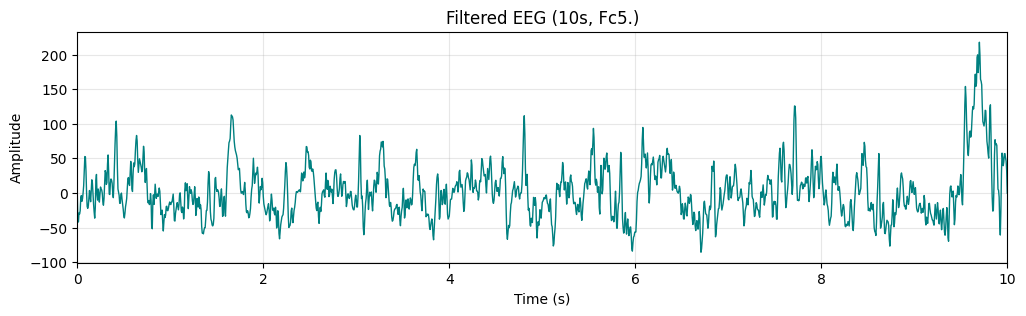

In [ ]:
plot_time_segment(
    signal=eeg_signal,
    time_segment=times,
    title=f"Filtered EEG (10s, {chosen_channel})",
    color='teal',
    downsample=1
)

## <a id='toc4_2_'></a>[Step 3.2: Short 0.5-second segment](#toc0_)

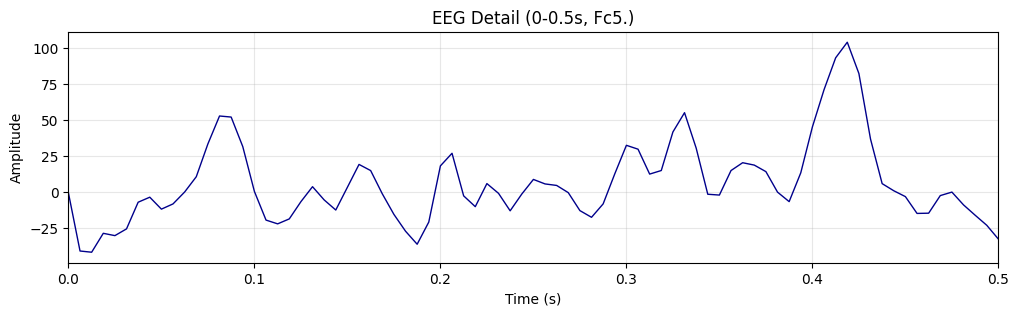

In [ ]:
short_time_segment = times[times <= 0.5]
plot_time_segment(
    signal=eeg_signal,
    time_segment=short_time_segment,
    title=f"EEG Detail (0-0.5s, {chosen_channel})",
    color='darkblue',
    downsample=1
)

# <a id='toc5_'></a>[Step 4: Frequency-Domain Analysis](#toc0_)

In [ ]:
xf, yf_mag = calculate_fft(
    signal=eeg_signal,
    sample_rate=eeg_sample_rate,
    normalize=True
)

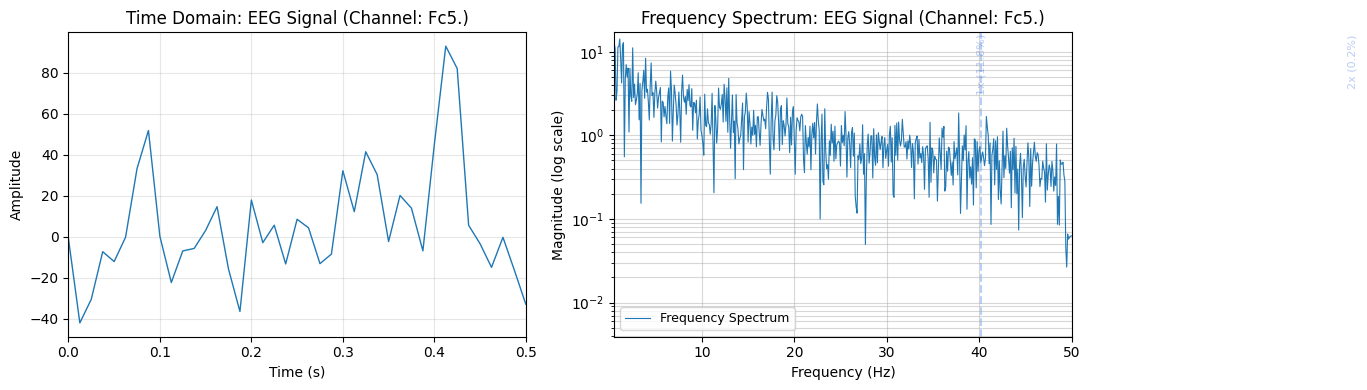

Dominant frequency in EEG: 1.10 Hz


In [ ]:
# Plot time vs frequency
dominant_freq = plot_signal_and_fft(
    signal=eeg_signal,
    t=times,
    time_segment=short_time_segment,
    sample_rate=eeg_sample_rate,
    title=f"EEG Signal (Channel: {chosen_channel})",
    fundamental_freq=np.median(xf[xf > 0.5]),  # Ignore sub-0.5 Hz noise
    xlim=(0.5, 50),  # Focus on relevant EEG frequencies
    downsample=2
)

print(f"Dominant frequency in EEG: {dominant_freq:.2f} Hz")

# <a id='toc6_'></a>[Step 5: Spectrogram](#toc0_)

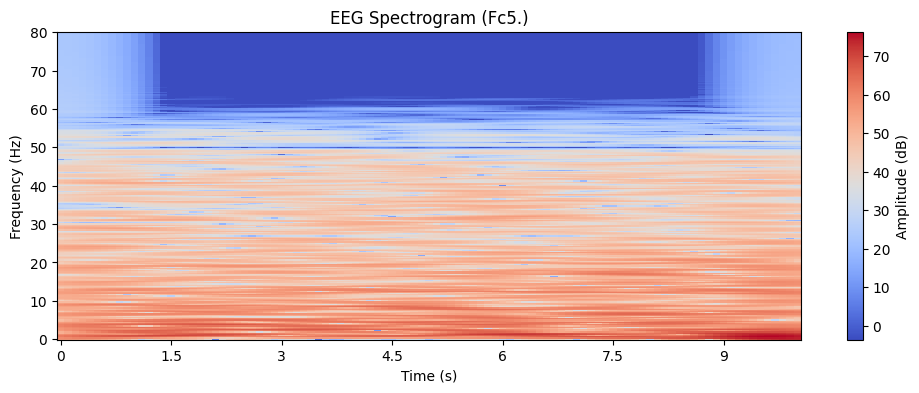

In [ ]:
plot_spectrogram(
    signal=eeg_signal,
    sample_rate=eeg_sample_rate,
    title=f"EEG Spectrogram ({chosen_channel})",
    n_fft=512,  # Smaller FFT for better time resolution with EEG
    hop_length=16
)

# <a id='toc7_'></a>[Step 6: EEG Band Analysis](#toc0_)

In [ ]:
eeg_bands = {
    'Delta (Deep Sleep)': (0.5, 4),
    'Theta (Drowsy)': (4, 8),
    'Alpha (Relaxed)': (8, 13),
    'Beta (Active)': (13, 30),
    'Gamma (High Activity)': (30, 50)
}

In [ ]:
print("\nEEG Band Amplitude Analysis (µV):")
for band, (low, high) in eeg_bands.items():
    band_mask = (xf >= low) & (xf <= high)
    if np.any(band_mask):
        avg_amp = np.mean(yf_mag[band_mask])
        print(f"{band} ({low}-{high} Hz): {avg_amp:.4f} µV")


EEG Band Amplitude Analysis (µV):
Delta (Deep Sleep) (0.5-4 Hz): 2.9957 µV
Theta (Drowsy) (4-8 Hz): 1.7422 µV
Alpha (Relaxed) (8-13 Hz): 1.1873 µV
Beta (Active) (13-30 Hz): 0.6016 µV
Gamma (High Activity) (30-50 Hz): 0.3660 µV


# <a id='toc8_'></a>[Step 7: Sonification](#toc0_)

In [ ]:
import numpy as np
from IPython.display import Audio  # Use IPython's native audio widget

# Audio parameters
audio_duration = 3  # seconds
audio_sample_rate = DEFAULT_SAMPLE_RATE  # Typically 44100 Hz
audio_length = int(audio_sample_rate * audio_duration)

# Resample EEG to match audio duration
eeg_resampled = np.interp(
    np.linspace(0, len(eeg_signal)-1, audio_length),
    np.arange(len(eeg_signal)),
    eeg_signal
)

# Normalize EEG signal to 0-1 range for frequency mapping
eeg_normalized = (eeg_resampled - np.min(eeg_resampled)) / (np.max(eeg_resampled) - np.min(eeg_resampled))

# Map EEG to audible frequencies (200-1000 Hz)
min_freq = 200
max_freq = 1000
audio_freq = min_freq + (max_freq - min_freq) * eeg_normalized

# Generate audio waveform
t_audio = np.linspace(0, audio_duration, audio_length, endpoint=False)
audio_signal = 0.5 * np.sin(2 * np.pi * audio_freq * t_audio)  # Sine wave carrier

# Normalize to prevent clipping
audio_signal = audio_signal / np.max(np.abs(audio_signal))

# Play using IPython's native Audio widget (simpler and more reliable)
print("EEG Sonification (3 seconds):")
Audio(audio_signal, rate=audio_sample_rate)